In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict):
    
    train_data_inp = []
    test_data_inp = []
    train_data_out = []
    test_data_out = []
    paths = [petmr_path, trio_path]
    
    for data_path in paths:
        if(data_path == petmr_path):
            print "Uploading Inputs:"
            training_data_store = train_data_inp
            testing_data_store = test_data_inp
        else:
            print "Uploading Outputs"
            training_data_store = train_data_out
            testing_data_store = test_data_out
        os.chdir(data_path)
        for key, subjs in scans_dict.iteritems():
            for subj_scan in subjs:
                scan_image = nib.load(str(data_path) + "/Subj" + subj_scan + "/Brain_Extracted.nii.gz")
                scan_data = scan_image.get_data()
                #all scans have the same affine mat because registration has already been performed
                #we only need it for saving the predictions as a NIfTI file
                affine_mat = scan_image.affine
                #get b=0 volumes only
                bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/Subj" + subj_scan + "/NODDI.bval",\
                                                          str(data_path) + "/Subj" + subj_scan + "/NODDI.bvec")
                #set a threshold value for b=0 values (due to TRIO dataset)
                gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
                s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
            
                if(key == "training"):
                    print ("Training: Subj%s" % subj_scan)
                    #append this data to the list containing the training data
                    training_data_store.append(s0s_scan)
                else:
                    print ("Testing: Subj%s" % subj_scan)
                    testing_data_store.append(s0s_scan)
    return (train_data_inp, train_data_out, test_data_inp, test_data_out, affine_mat)

In [41]:
def analysis(scan, title, percentile):
    
    mask = scan>0
    brain = scan[mask]
    
    
    print("maximum: %d" % brain.max())
    print("minimum: %d" % brain.min())
    print("average: %d" % brain.mean())
    print("99th percentile: %d\n" % np.percentile(brain, percentile))

    print("Total number of voxels: %d" % brain.shape[0])
    print("Voxels greater than %d percentile value: %d" % (percentile, (brain>np.percentile(brain,99)).sum()) )

    plt.hist(brain.flatten(), bins = 50);
    plt.title(title)



In [74]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
trio_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data'

#training_scans = ["1Scan1", "1Scan2", "2Scan1","2Scan2","3Scan1","3Scan2","4Scan1","4Scan2","5Scan1", \
 #               "5Scan2","6Scan1","6Scan2","7Scan1","7Scan2","8Scan1","8Scan2",]

training_scans = ["1Scan1"]

testing_scans = ["1Scan1", "9Scan1"]

(training_data_inp, training_data_out, testing_data_inp, testing_data_out, affine_mat) = \
        get_data(petmr_data_path, trio_data_path, {"training":training_scans, "testing":testing_scans})

print ("Number of scans used for training input: %d" % len(training_data_inp))
print ("Number of scans used for training output: %d" % len(training_data_out))
print ("Number of scans used for testing input: %d" % len(testing_data_inp))
print ("Number of scans used for testing output: %d" % len(testing_data_out))

Uploading Inputs:
Training: Subj1Scan1
Testing: Subj1Scan1
Testing: Subj9Scan1
Uploading Outputs
Training: Subj1Scan1
Testing: Subj1Scan1
Testing: Subj9Scan1
Number of scans used for training input: 1
Number of scans used for training output: 1
Number of scans used for testing input: 2
Number of scans used for testing output: 2


------------------------------------------------------------------------------------------------------------
--

------------------------------------------------------------------------------------------------------------
--

maximum: 4095
minimum: 1
average: 398
99th percentile: 1852

Total number of voxels: 818045
Voxels greater than 99 percentile value: 8174


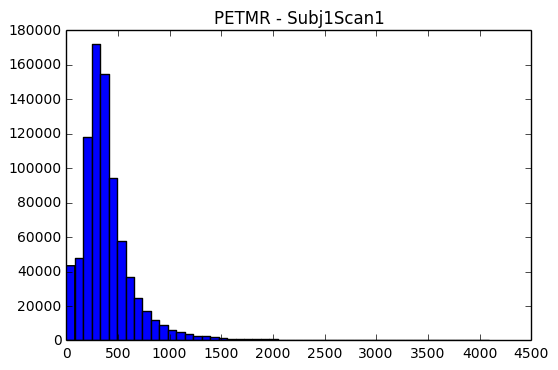

In [75]:
analysis(testing_data_inp[0], "PETMR - Subj1Scan1", 99.5)

maximum: 1662
minimum: 2
average: 298
99th percentile: 897

Total number of voxels: 818298
Voxels greater than 99 percentile value: 8154


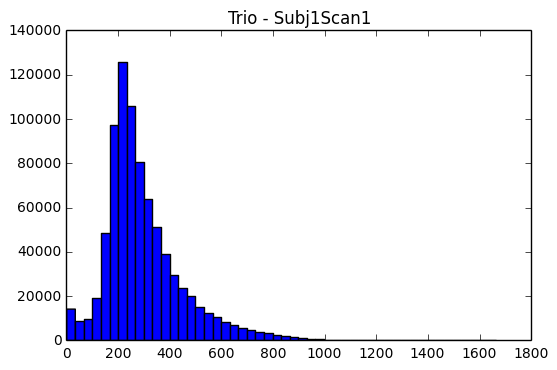

In [76]:
analysis(testing_data_out[0], "Trio - Subj1Scan1", 99.5)

maximum: 3499
minimum: 1
average: 393
99th percentile: 1639

Total number of voxels: 1044028
Voxels greater than 99 percentile value: 10415


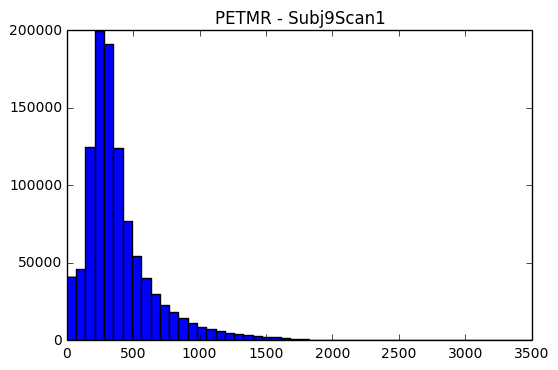

In [77]:
analysis(testing_data_inp[1], "PETMR - Subj9Scan1", 99.5)

maximum: 3376
minimum: 3
average: 354
99th percentile: 1325

Total number of voxels: 1044160
Voxels greater than 99 percentile value: 10405


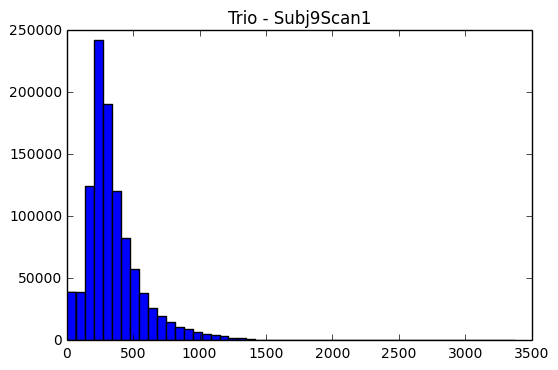

In [78]:
analysis(testing_data_out[1], "Trio - Subj9Scan1", 99.5)

In [69]:
capped = testing_data_out[1]
capped[capped>1170] = 1170

In [59]:
save_to = "/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj9Scan1"

capped_scan = nib.Nifti1Image(capped, affine_mat)
nib.save(capped_scan, save_to + "/Capped_Scan.nii.gz" )